# Nonlinear Elasticity in a multipatch domain


In [1]:
# Here only constant load over x-axis(length) possible!

In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

# line search
from scipy.optimize import line_search

from geo_annulus import *
from plots import *
from ass_nonlin_el import *
from solver import *
from line_search import *


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
 no MKL


In [2]:
# 3 D #
p = 3 # spline degree
multi= 1
n_el = (12, 3, 6)  # number of elements in x, y, z direction, isotropic material
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from mpl_toolkits import mplot3d

def plot_geo(geo, grid=10, gridx=None, gridy=None, gridz= None,
             res=30,
             linewidth=None, color='black',  **kwargs):
    """Plot a wireframe representation of a 2D geometry."""
    #fig = plt.figure()
    
    if geo.sdim == 1 and geo.dim == 2:
        print("plot_curve")
        return plot_curve(geo, res=res, linewidth=linewidth, color=color)
    
    #print("geo.sdim:", geo.sdim)
    #print("geo.dim:", geo.dim)
    
    if geo.dim == geo.sdim == 2:
        #assert geo.dim == geo.sdim == 2, 'Can only plot 2D geometries'
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        supp = geo.support

        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotline(pts, capstyle='butt'):
            plt.plot(pts[:, 0], pts[:, 1], color=color, linewidth=linewidth,
                     solid_joinstyle='round', solid_capstyle=capstyle)

        pts = grid_eval(geo, (gridx, meshy))
        plotline(pts[0, :, :], capstyle='round')
        for i in range(1, pts.shape[0] - 1):
            plotline(pts[i, :, :])
        plotline(pts[-1, :, :], capstyle='round')

        pts = grid_eval(geo, (meshx, gridy))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

    
    if geo.sdim == geo.dim == 3:
        #print("3D geometry")
        # syntax for 3-D projection
        #ax = plt.axes(projection ='3d')
        #assert geo.dim == geo.sdim == 3, 'Can only plot 3D geometries'
        
        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx)
            #print(gridx)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res)
        #print(meshx)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotline(pts, capstyle='butt'):
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], cmap=cm.coolwarm, linewidth=linewidth,  **kwargs)

        pts = grid_eval(geo, (gridx, meshy, meshz))# meshy
        plotline(pts[0, :, :], capstyle='round')# beginning
        for i in range(1, pts.shape[0] - 1): 
            plotline(pts[i, :, :]) # inbetween
        plotline(pts[-1, :, :], capstyle='round') # end

        pts = grid_eval(geo, (meshx, gridy, meshz))
        plotline(pts[:, 0, :], capstyle='round')
        for j in range(1, pts.shape[1] - 1):
            plotline(pts[:, j, :])
        plotline(pts[:, -1, :], capstyle='round')

        pts = grid_eval(geo, (meshx, meshy, gridz))
        plotline(pts[:, :, 0], capstyle='round')
        for k in range(1, pts.shape[2] - 1): 
            plotline(pts[:, :, k])
        plotline(pts[:, :, -1], capstyle='round')

        # plotting
        #ax.set_title('3D line plot')
        #plt.show()


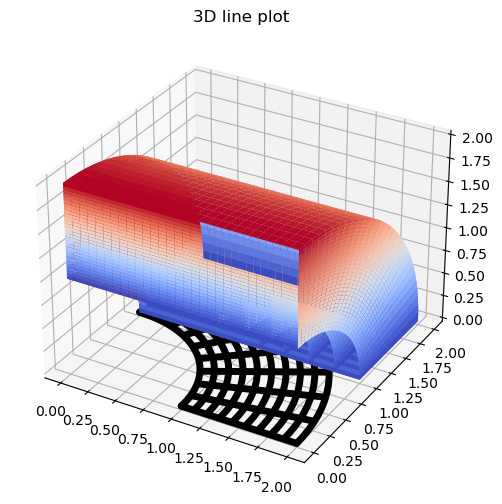

In [4]:
G = geometry.tensor_product(geometry.quarter_annulus(), geometry.line_segment(0,2))
G2 =  geometry.quarter_annulus()
#G = geometry.tensor_product(geometry.line_segment(0,1), geometry.quarter_annulus())
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plot_geo(G) #vmin=0.0, vmax=2.5e-2 3D

plot_geo(G2, linewidth=5) #vmin=0.0, vmax=2.5e-2 2D
ax.set_title('3D line plot')
plt.show()

In [5]:
# define geometry
r_in = 1.93 #mm
r_out = 2.25 #mm

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]


# 3D
#geos_3d = [geometry.tensor_product(geometry.line_segment(0,1), g) for g in geos]
geos_3d = [geometry.tensor_product(g, geometry.line_segment(0,5)) for g in geos]

In [6]:
patches_u = [(kvs_u, g) for g in geos_3d] # 3D

# Here we auto-detect the interfaces between the patches.
MP_u = assemble.Multipatch(patches_u, automatch=True) #3D

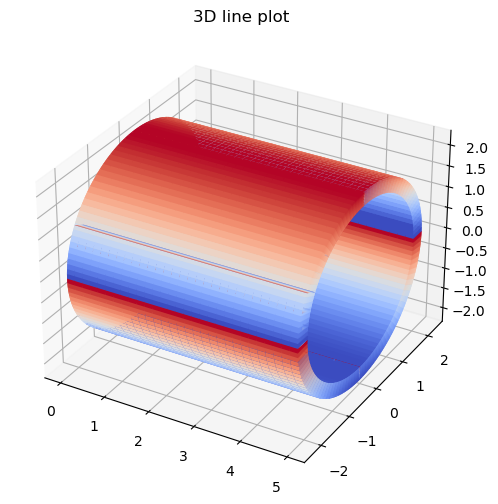

In [7]:
figsize(8,6)
fig = plt.figure()
ax = plt.axes(projection ='3d')

for g in geos_3d:
    plot_geo(g)#, vmin=0, vmax=7.5)

ax.set_title('3D line plot')
plt.show()

In [8]:
# define boundary conditions

In [9]:
# source term f, 3D
def f(x, y, z): return (0.0, 0.0, 0.0)

In [10]:
# Multipatch objects for all variables (x, y, z)
MP_block = multipatch_block_handler( [MP_u, MP_u, MP_u] ) 

In [11]:
# define Dirichlet boundary function 
def g_zero(x, y, z): return (0.0, 0.0, 0.0) # fixed in y/z, x runs, evtl. set x=x

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'top', g_zero ) # outer bd, 1
])

In [12]:
# not needed! --> use implemented normal vector in assembling routine!
#Neumann BC #
def gN0(x, y, z): 
#quarter annulus in y/z coord.system
    return (0, y/r_in*l_val, z/r_in*l_val) # inner pressure, in normal direction (0, 1, 1)

# quarter annulus in x/y coord.system
   # return (x/r_out*loading_value, y/r_out*loading_value, 0)  #inner  pressure, normalized vector


In [13]:
# Robin BC
def g_robin(x, y, z): return 0 # hom. Robin bd cond
#def g_robin(x, y, z): 
    #return (1-(y/r_out+ z/r_out)**2) # scalar value
   

In [14]:
# Compute solution of nonlinear elasticity problem

In [15]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [16]:
M = ass_mass3d(MP_block)
Minv = make_solver(M)

use SuperLU


In [17]:
#incremental loading
# pressure: 13.33 kPa --> 100mmHg
#           10.664 kPa --> 80mmHg
# p_int:    2.666 kPa ---> 20mmHg
maxload = 2.666e-3 #1.5e-3 #13.33*1e-3 #1.5e-2 #2e-3
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)


In [18]:
def alpha(x, y, z): return ( 1-(y/r_out+ z/r_out)**2) * 1e-2 # scalar value
#alpha =1e-2 #1e-2# 1.5e3# 1e0 # 1e4 max penalization!
robin_data = [(1, 'top', g_robin, alpha)] # instead of Dirichlet-bdc, outer bd fixed

In [19]:
# assemble Robin-matrix
AR = ass_Robin3d(MP_block, robin_data)

In [20]:
def J(u):
    return ass_energy3d(u, MP_block, kvs_j, neu_data, robin_data)


def grad_J(u):
    return -ass_rhs_RN3d(u, MP_block, neu_data, AR)


In [21]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
l_val = loading[-1] # take last loading value
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

### first iteration ###
A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR) # with Robin-matrix


r0 = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual0 =', r0)
print('Energy0   =', J(u))

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver(A).dot(b) 
u += u_d

#A, b = ass_nonlinsystem(u, MP_block, neu_data, AR) 
#print('rhs:', b)
b= ass_rhs_RN3d(u, MP_block, neu_data, AR)

r = np.transpose(b).dot(Minv.dot(b)) #L2-norm
print('Residual  =', r)
print('Energy    =', J(u))

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###
#get_defplotC(u, patches_u, kvs_u, MP_u)


Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod318b7eb3318eb4be.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod318b7eb3318eb4be.pyx


Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modaed3b148f68d3695.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modaed3b148f68d3695.pyx
Residual0 = 0.04279598200667796
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb64b2631a7dc9b4f.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb64b2631a7dc9b4f.pyx
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modc989de942328a628.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modc989de942328a628.pyx
Energy0   = 0.0
use SuperLU
Residual  = 27.61374339432545
Energy    = -0.012160088554266472


In [23]:
def get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u, grid=2, gridx=None, gridy=None, gridz= None,
             res=20, linewidth=None, **kwargs):
    vrange= None
    # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

        if gridx is None: gridx = grid
        if gridy is None: gridy = grid
        if gridz is None: gridz = grid
        supp = geo.support
        
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridx):
            gridx = np.linspace(supp[0][0], supp[0][1], gridx) # e.g. linespace(0, 1, 10)
        if np.isscalar(gridy):
            gridy = np.linspace(supp[1][0], supp[1][1], gridy)
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][0], supp[2][1], gridz)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1],**kwargs)

        xgridyz = (gridx,gridx, gridx)
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
    
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
    
        #C = np.sqrt( np.power(dis[..., 0], 2)+np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])

        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   
        
        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
    
    vrange = (C.min(), C.max())
    #vrange = (0, 1.5e-5)
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)


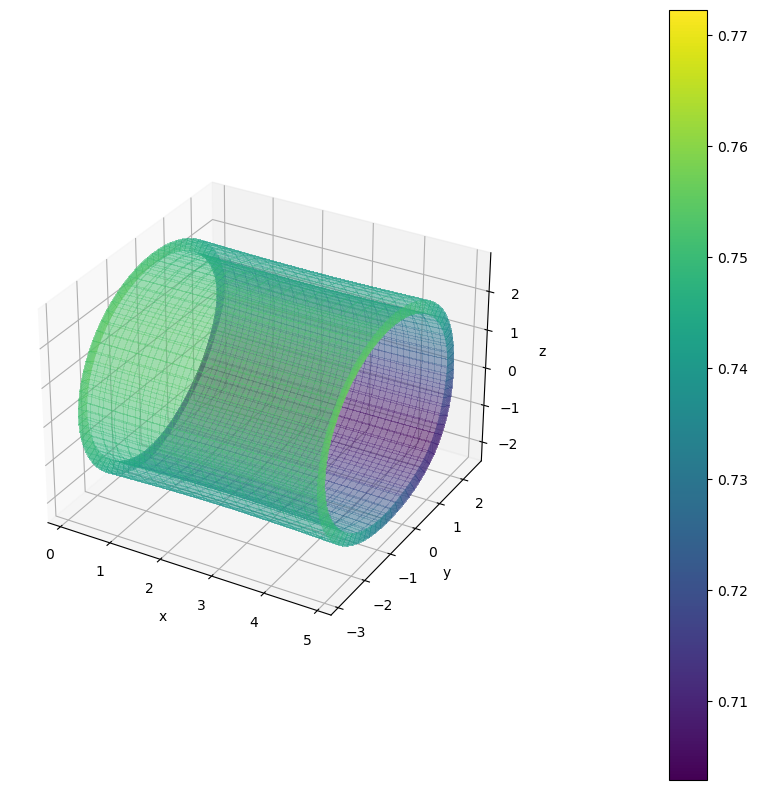

In [24]:

#u= LS.complete(u)
"""Split solution vector into displacement components."""
u1 = u[:MP_u.numdofs] 
u2 = u[MP_u.numdofs:2*MP_u.numdofs]
u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

# restrict solution to each individual patch - BSpline functions
u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
       for p in range(len(patches_u))]
u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
       for p in range(len(patches_u))]
u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
       for p in range(len(patches_u))]

figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d')
get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.savefig('robin2d_1.png')

plt.show()
    

In [25]:
def get_u_funcs3d(u, patches_u, kvs_u, MP_u, **kwargs):
    
    #u= LS.complete(u)
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
    
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    return (u1_funcs, u2_funcs, u3_funcs)
    

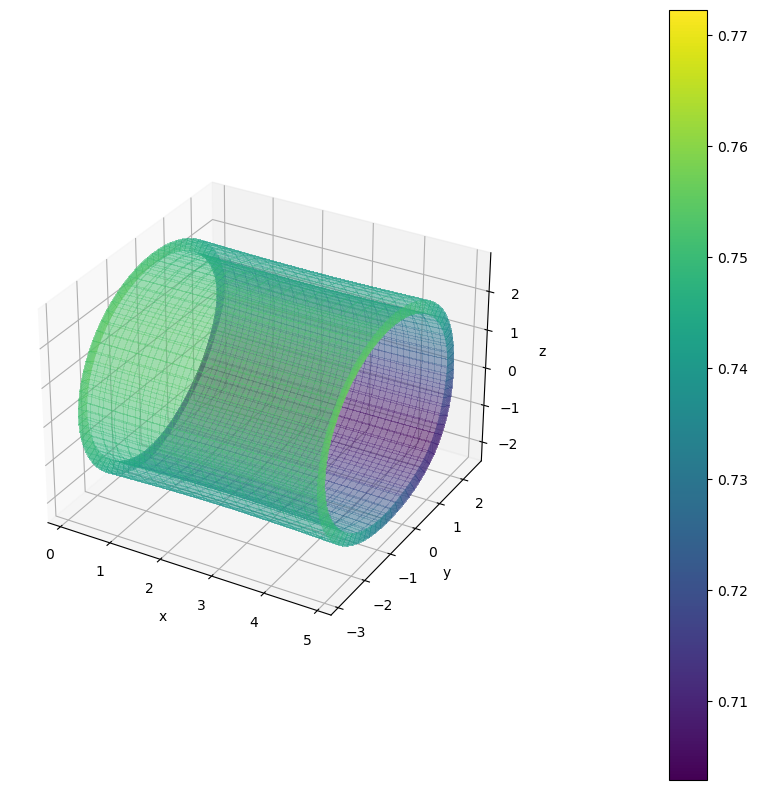

In [26]:
figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d')
u1_funcs, u2_funcs, u3_funcs= split_u3d(u, MP_u, kvs_u, patches_u)
get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()


 patch: 0
displacement_inner= [[8.33274422e-14 1.71744164e-01 2.14133347e-01]]
displacement_outer= [[-9.69710423e-15  1.33492337e-01  2.02963063e-01]]
(20, 20, 1)
inner_radius:  2.1126243443668433
inner_radius:  2.1126243443668433
dis_inner_y/dis_outer_y:  1.2865469835669174
dis_inner_z/dis_outer_z:  1.0550360419165303

 patch: 1
displacement_inner= [[-3.29770933e-15 -2.14133346e-01 -1.71744164e-01]]
displacement_outer= [[-6.34561848e-15 -2.02963063e-01 -1.33492337e-01]]
(20, 20, 1)
inner_radius:  2.1126243443626613
inner_radius:  2.1126243443626613
dis_inner_y/dis_outer_y:  1.0550360419036096
dis_inner_z/dis_outer_z:  1.2865469835757681

 patch: 2
displacement_inner= [[ 5.89967311e-13 -6.64194113e-01  2.24258231e-01]]
displacement_outer= [[ 5.52176360e-13 -6.29231376e-01  2.25259694e-01]]
(20, 20, 1)
inner_radius:  2.60386920723148
inner_radius:  2.60386920723148
dis_inner_y/dis_outer_y:  1.055564197987056
dis_inner_z/dis_outer_z:  0.9955541828708149

 patch: 3
displacement_inner= [[

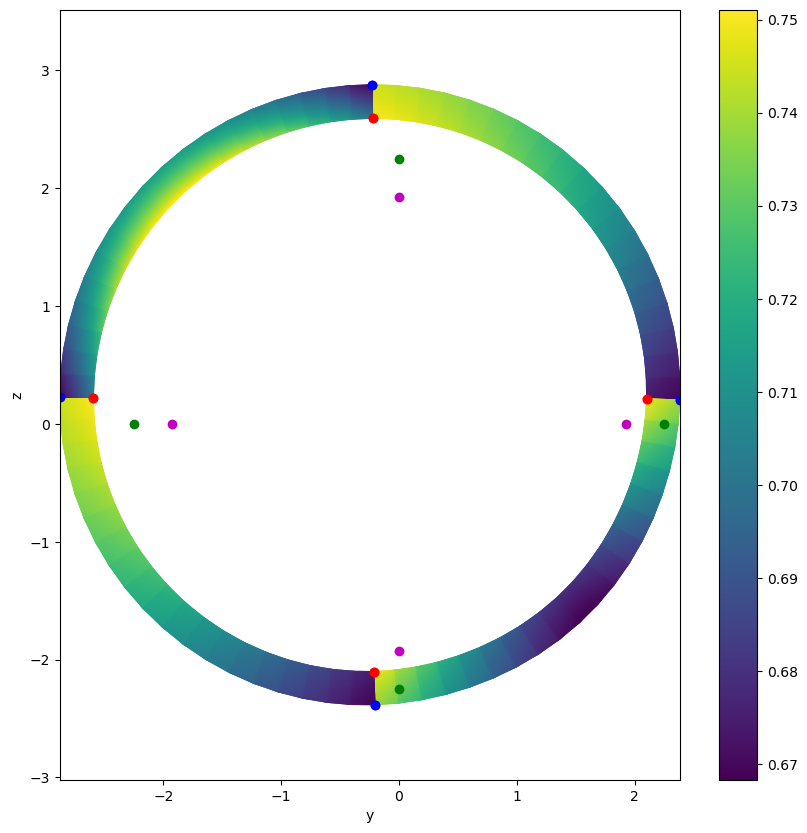

In [27]:
get_defplotpp3d(u, patches_u, kvs_u, MP_u, n_el)

 
 
 1. loading: 0.0008886666666666666 

0
Energy   = 0.0
Error= 0.08699278439168881
1
Energy   = -0.003364480005266155
Error= 0.020902711887667246
2
Energy   = -0.0035847414714231945
Error= 0.001424634053548157
3
Energy   = -0.00358551985306239
Error= 0.00011881100486880558
4
Energy   = -0.003585539740738542
Error= 5.000135487314109e-07
5
Energy   = -0.003585540551666673
Error= 4.178515119382483e-11
6
Energy   = -0.003585540551691076
Error= 7.420000165516586e-16
u=  [0.05940986 0.05244124 0.03736679 ... 0.07679982 0.07656975 0.07640998]
 
 
 2. loading: 0.0017773333333333335 

0
Energy   = -0.010571321879642387
Error= 0.08049571686108872
1
Energy   = -0.013564027295065464
Error= 0.015678472839122857
2
Energy   = -0.013686863624222289
Error= 0.00031050026881072033
3
Energy   = -0.01368610007022589
Error= 2.0276055557053834e-06
4
Energy   = -0.013686097875822145
Error= 2.9226576390666707e-10
5
Energy   = -0.01368609787386957
Error= 1.3943124928868632e-15
u=  [0.11302375 0.09960502 0.070

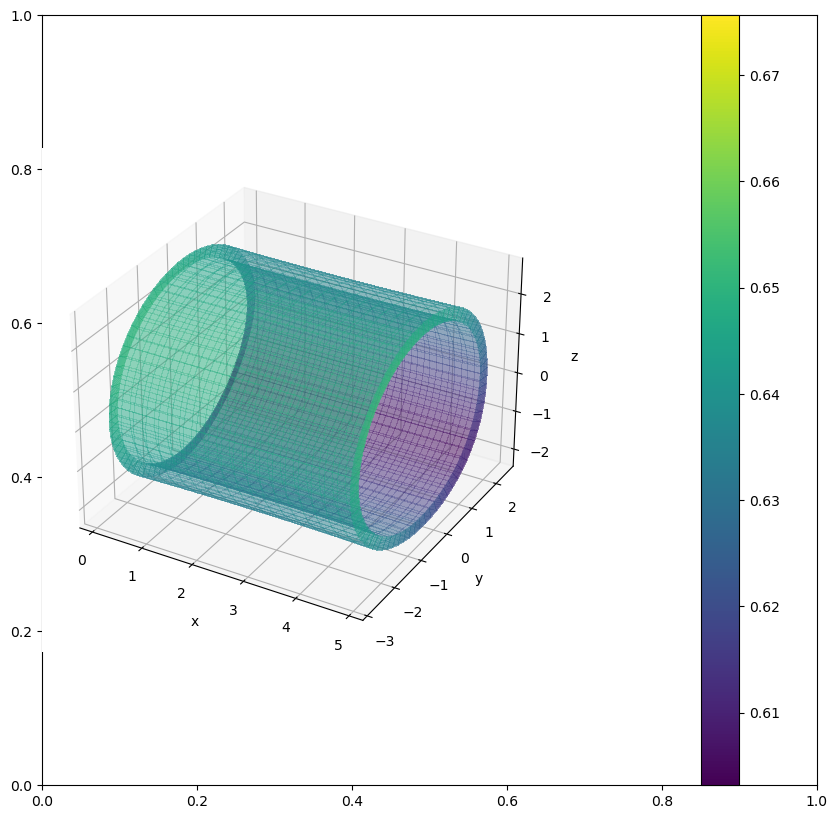

In [28]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []
vol= []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

    count = 0
    while True:
        print(count)
        
        A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
        print('Energy   =',J(u))
        u_d = make_solver(A).dot(b)
        ## error measure in H1*
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        #if r < epsilon * r0: # break condition
        if abs(err) < max_err:
            break
        elif count == 25:
            break
        
        count+=1
        
        u += u_d  
        
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
    
    #loc_vol= local_vol (u, MP_block)
    #vol.append(loc_vol)
    
        
get_defplotC(u, patches_u, kvs_u, MP_u)

In [29]:
sum(iter_counts)

16

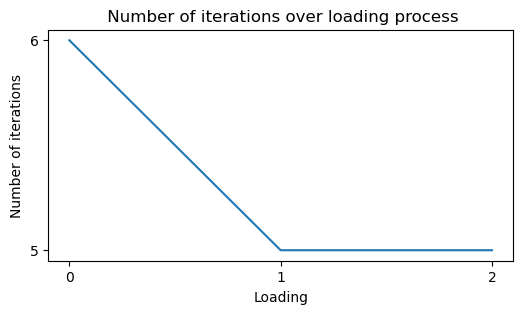

In [30]:
figsize(6,3)
fig, ax= plt.subplots()

s_cts= shape(iter_counts)[0]
plot(range(s_cts), iter_counts)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title(' Number of iterations over loading process');
xlabel('Loading'); ylabel('Number of iterations');

In [31]:
s_sol= shape(solutions)[0]

In [32]:
"""Visualization functions."""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection


def animate_field_3d(fields, patches_u, kvs_u, vrange=None, res=50,cmap=None, interval=50, progress=False):
    """Animate a sequence of scalar fields over a geometry."""
    
    figsize(10,10)
    fig = plt.figure()
    ax = plt.axes(projection ='3d') #,xlim=(0, 2), ylim=(-0.5, 0.5)
    
    fields = list(fields)
    ar= np.linspace(1,20, s_sol)
    factor = ar[0]
    vrange = None

    # first solution
    #u= LS.complete(fields[0])
    u= fields[0]
    
    #Split solution vector into displacement components
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]
    u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
           for p in range(len(patches_u))]
    
    def plotlineC(pts, C, capstyle='butt'):
            #C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            #print(shape(C))
            vrange = (C.min(), C.max())
            #vrange = (0, 1.5e-5)
            
            norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3,facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            #ax.plot_wireframe(pts[..., 0], pts[..., 1], pts[..., 2], linewidth=1, color='grey') # grid
            #ax.plot_surface(pts[..., 0], pts[..., 1], pts[..., 2], facecolors=colors, linewidth=0) # checkerboard
    
    def plotline(pts, capstyle='butt'):
            C = np.sqrt(np.power(pts[..., 1], 2) + np.power(pts[..., 2],2))
            vrange = (C.min(), C.max())
            ax.plot_surface(factor*pts[..., 0], factor*pts[..., 1], factor*pts[..., 2], linewidth=0, antialiased=False, shade = False, alpha = 0.3, facecolors=cm.viridis(C), vmin=vrange[0], vmax=vrange[1])
            ax.set_xlim3d(left=0, right=5.5)
            ax.set_ylim3d(bottom=-7, top=4.5)
            #ax.set_zlim3d(bottom=-0.5, top=0.5)
            ax.set_zbound(lower=-5.5, upper=5.5)
            
    
     # visualization per patch
    for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        supp = geo.support
        
        gridx = np.linspace(supp[0][0], supp[0][1], 2) # e.g. linespace(0, 1, 2)
        gridy = np.linspace(supp[1][0], supp[1][1], 2)
        gridz = np.linspace(supp[2][0], supp[2][1], 2)

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)
        meshz = np.linspace(supp[2][0], supp[2][1], res)
        
        
        ygridxz = (meshx, gridy, meshz)
        zgridxy = (meshx, meshy, gridz)
        
        # y-grid 
        dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(ygridxz) #y-value
        dis3 = u3_func.grid_eval(ygridxz) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid
      
        #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        #vrange = (C.min(), C.max())
        
        pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, 0, :], C[:, 0, :])
        for j in range(1, pts.shape[1] - 1):
            plotlineC(pts[:, j, :], C[:, j, :])
        plotlineC(pts[:, -1, :], C[:, -1, :])
        
        
        
        ##'''
        # z-grid
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1])
        
    vrange = (C.min(), C.max())
    norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])   
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, pad=0.2)
    #plt.show()
  
    #fig.colorbar(quadmesh, ax=ax);
    #colorbar();
    tqdm = vis.utils.progress_bar(progress)
    pbar = tqdm(total=len(fields))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    
    def anim_func(i):
        plt.cla()
        
        vrange= None
        factor = ar[i] # choose factor for deformation plot
        u= fields[i]
        #u = LS.complete(fields[i])

        #Split solution vector into displacement components
        u1 = u[:MP_u.numdofs] 
        u2 = u[MP_u.numdofs:2*MP_u.numdofs]
        u3 = u[2*MP_u.numdofs:3*MP_u.numdofs]

        # restrict solution to each individual patch - BSpline functions
        u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
               for p in range(len(patches_u))]
        u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
               for p in range(len(patches_u))]
        u3_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u3)
               for p in range(len(patches_u))]
        
             # visualization per patch
        for (u1_func, u2_func, u3_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 

            # y-grid 
            dis1 = u1_func.grid_eval(ygridxz) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(ygridxz) #y-value
            dis3 = u3_func.grid_eval(ygridxz) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))

            pts = grid_eval(geo, ygridxz) + dis  # + displacement y-coord
            C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, 0, :], C[:, 0, :])
            for j in range(1, pts.shape[1] - 1):
                plotlineC(pts[:, j, :], C[:, j, :])
            plotlineC(pts[:, -1, :], C[:, -1, :])

            # z-grid
            dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
            dis2 = u2_func.grid_eval(zgridxy) #y-value
            dis3 = u3_func.grid_eval(zgridxy) #z-value
            dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

            #C = np.sqrt(np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            #vrange = (C.min(), C.max())
            #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])

            pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
            C = np.sqrt(np.power(dis[..., 0], 2)+ np.power(dis[..., 1], 2) + np.power(dis[..., 2],2))
            plotlineC(pts[:, :, 0],C[:, :, 0])
            for k in range(1, pts.shape[2] - 1): 
                plotlineC(pts[:, :, k], C[:, :, k])
            plotlineC(pts[:, :, -1], C[:, :, -1])
        
            pbar.update()
            if i == len(u) - 1:
                pbar.close()
        #vrange = (C.min(), C.max())
        #norm = mpl.colors.Normalize(vmin=vrange[0], vmax=vrange[1])
            
    return animation.FuncAnimation(plt.gcf(), anim_func, frames=len(fields), interval=interval, repeat=False)

16it [00:06,  2.49it/s]                                                                                                                                     


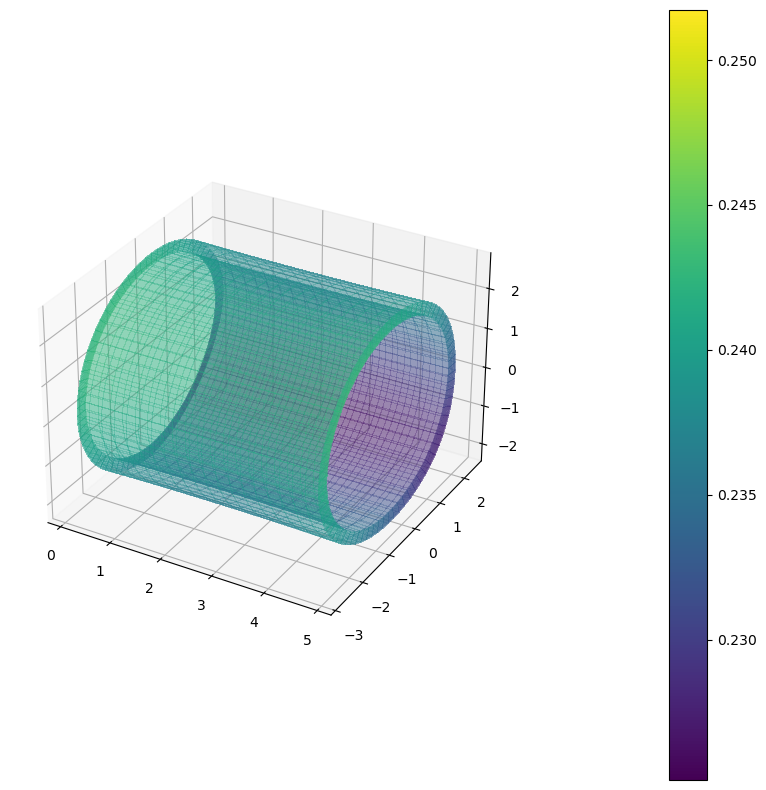

In [33]:
from IPython.display import HTML

figsize(14, 4)
#fields = [ud_array[tt] for tt in range(s_sol)]
fields = [solutions[tt] for tt in range(s_sol)] ## time steps
HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=535, progress=True).to_html5_video())
#writervideo = animation.FFMpegWriter(fps=300)
#HTML(animate_field_3d(fields, patches_u, kvs_u, res=20, interval=600, progress=True).save('Robin3d15.mp4', writer=writervideo))

In [22]:
# solve linearized variational problem - loading, solve exact in last step

#initial value
u= np.zeros(dd)
u_d= u

epsilon= 1e-11# 1e-5
max_err = 1e-11

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    l_val = loading[t]
    neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann


    count = 0
    while count <len(loading)-2:
        count+=1
        print(count)
        A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
        r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm
        print('Residual =',r)
        print('Energy   =',J(u))
       
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d = make_solver(A).dot(b)
        u += u_d  
        
        w= np.inner(np.transpose(u_d),b)
        err = np.sqrt(np.abs(w))
        print('Error=', err)
        
        ud_array.append(u_d)
        normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        

    solutions.append(np.array(u))
    iter_counts.append(count)
    count=0

# solve solution exact on max. loading 
while True:
    A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
    r = np.transpose(b).dot(Minv.dot(b)) #dual of L2-norm

    print('residual =', r)
    print('energy   =', J(u))
    
    # # solve system # #
    u_d = make_solver(A).dot(b)
    
    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)
    
    if abs(err) < max_err:
        break
    elif count == 20:
        break
    
    count+=1 # count only, when system is solved
    print(count)
    # update u
    u += u_d 
    
    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#
    
ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)
        

 
 
 1. loading: 0.0008886666666666666 

1
Residual = 0.004755109111853105
Energy   = 0.0
use SuperLU
Error= 0.08699278439177653
 
 
 2. loading: 0.0017773333333333335 

1
Residual = 0.4940170104578305
Energy   = -0.01093652072164654
use SuperLU
Error= 0.0723447504996016
 
 
 3. loading: 0.002666 

1
Residual = 0.17584997473843492
Energy   = -0.02653777768759558
use SuperLU
Error= 0.07716249860104718
residual = 0.15846376778743376
energy   = -0.02948377789426653
use SuperLU
Error= 0.012750312014420204
1
residual = 1.5162981229177405e-05
energy   = -0.02956470049479367
use SuperLU
Error= 0.0009875706213476668
2
residual = 3.143303158312222e-05
energy   = -0.02955957502205374
use SuperLU
Error= 0.00015840958792415644
3
residual = 1.290018367681215e-10
energy   = -0.029559664489788005
use SuperLU
Error= 1.977860947049142e-06
4
residual = 2.3407893202248183e-15
energy   = -0.029559672866386784
use SuperLU
Error= 1.1482059547573168e-09
5
residual = 1.504903630649514e-26
energy   = -0.029559

NameError: name 'get_defplotU' is not defined

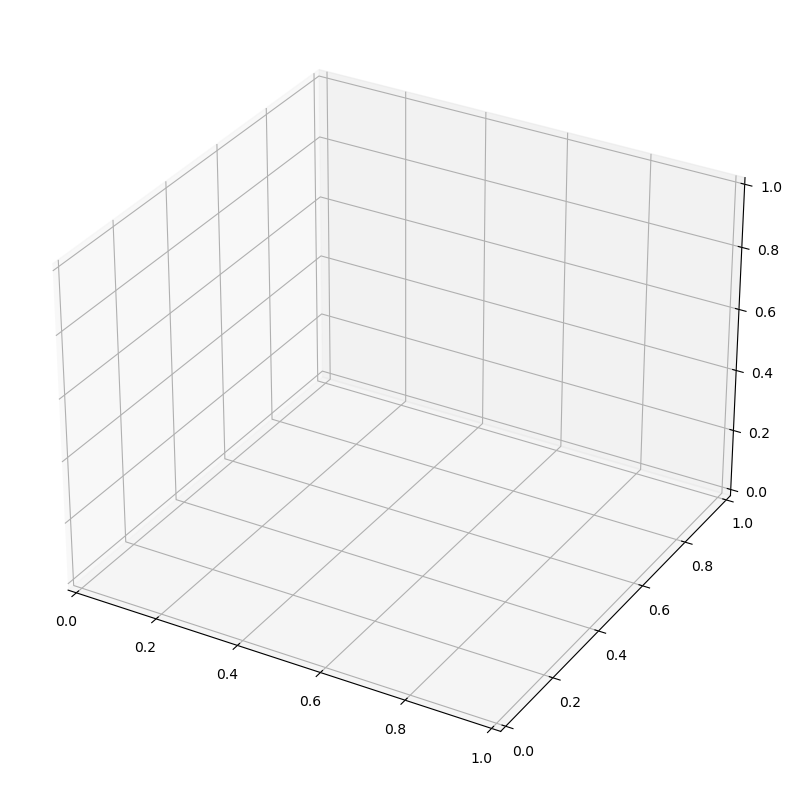

In [23]:
figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d')
u1_funcs, u2_funcs, u3_funcs= split_u3d(u, MP_u, kvs_u, patches_u)
get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.savefig('robin3d_1.png', transparent=True)

plt.show()

In [24]:
sum(iter_counts)

8


 patch: 0
displacement_inner= [[-5.20417043e-18  1.31971121e-01  1.81312022e-01]]
displacement_outer= [[-1.56125113e-17  9.48793861e-02  1.79834043e-01]]
(20, 20, 1)
inner_radius:  2.0699272818408483
inner_radius:  2.0699272818408483
dis_inner_y/dis_outer_y:  1.390935651115014
dis_inner_z/dis_outer_z:  1.0082185721421904

 patch: 1
displacement_inner= [[-3.46944695e-17 -1.81312022e-01 -1.31971121e-01]]
displacement_outer= [[-2.77555756e-17 -1.79834043e-01 -9.48793861e-02]]
(20, 20, 1)
inner_radius:  2.0699272818408483
inner_radius:  2.0699272818408483
dis_inner_y/dis_outer_y:  1.008218572142191
dis_inner_z/dis_outer_z:  1.390935651115013

 patch: 2
displacement_inner= [[ 3.46944695e-17 -5.52820541e-01  2.08272742e-01]]
displacement_outer= [[ 9.54097912e-17 -5.19935042e-01  2.05885057e-01]]
(20, 20, 1)
inner_radius:  2.4915407627382273
inner_radius:  2.4915407627382273
dis_inner_y/dis_outer_y:  1.0632492436540704
dis_inner_z/dis_outer_z:  1.0115971778215747

 patch: 3
displacement_inne

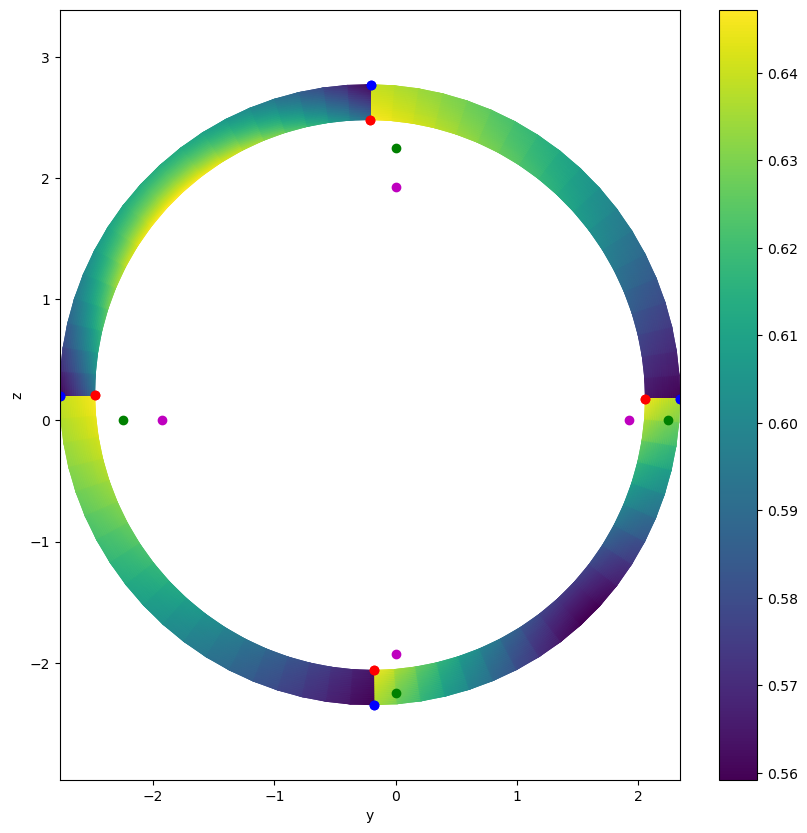

In [25]:
get_defplotpp3d(u, patches_u, kvs_u, MP_u, n_el)

In [26]:
cs = cauchystress3d(u, MP_block)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modd0b07971d6522768.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modd0b07971d6522768.pyx
use SuperLU


In [27]:
max(cs)

0.000542769470174184

In [28]:
min(cs)

0.0001684118335128783

In [29]:
vol_ratio= global_vol3d(u, MP_block, kvs_j)

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod8713b7481afbe489.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\mod8713b7481afbe489.pyx
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb5f24299fc5a85ac.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modb5f24299fc5a85ac.pyx


In [30]:
vol_ratio

0.24041879651195364

In [39]:
# for scalar-valued input vector
def get_defplot_scalar3d(val,u, patches_u, kvs_u, MP_u, n_el, geos, arr, res=30):
    val_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ val)
               for p in range(len(patches_u))]

    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)   
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    vrange= None
    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (val_func,u1_func, u2_func, u3_func, (kvs, geo)) in zip(val_funcs, u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        gridz= 1
        supp = geo.support
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][1]/2, supp[2][1]/2, 1) # evaluate in the middle 

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #vrange = (C.min(), C.max())
            #vrange = (-2.5e-4, 5.5e-4)
            vrange = (arr.min(), arr.max())
            #vrange = (2e-4, 5.5e-4)

            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', vmin=vrange[0], vmax=vrange[1])


        zgridxy = (meshx, meshy, gridz)
        # z-grid
        vol = val_func.grid_eval(zgridxy) #x-value
        G= grid_eval(geo, zgridxy)
        C  = vol
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts = grid_eval(geo, zgridxy) # z-coord ## undeformed
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1]) 

       #if vrange is None:
            #vrange = (C.min(), C.max())
        
        
    plt.colorbar();
    plt.axis('equal')
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    plt.show()
    #plt.savefig('rob3d_cs.png')
 
    

use SuperLU


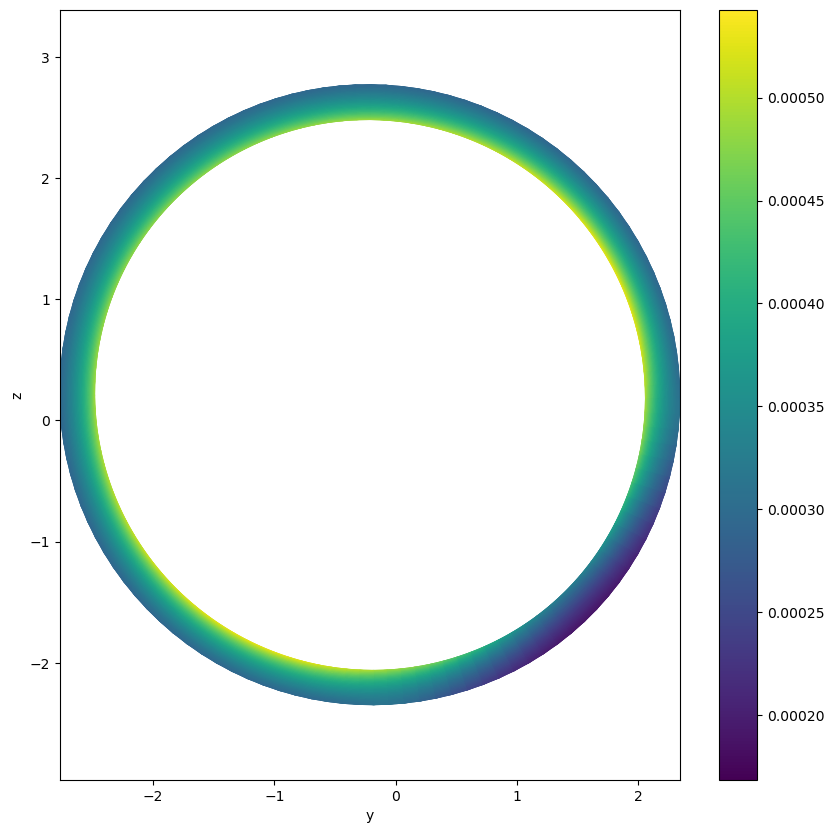

<Figure size 1000x1000 with 0 Axes>

In [40]:
# Cauchy-stress
get_defplot_scalar3d(cauchystress3d(u, MP_block),u,  patches_u, kvs_u, MP_u, n_el, geos, cs)

In [33]:
local_vol3d(u, MP_block)

use SuperLU


array([0.95428134, 0.94963064, 0.94693993, ..., 0.97132429, 0.97080868,
       0.96994403])

In [34]:
lvol= local_vol3d(u, MP_block)

use SuperLU


In [35]:
max(lvol)

0.9826507591308606

In [36]:
min(lvol)

0.9449790049464553

In [37]:
# for scalar-valued input vector
def get_defplot_scalar3d(val,u, patches_u, kvs_u, MP_u, n_el, geos, arr, res=30):
    val_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ val)
               for p in range(len(patches_u))]

    u1_funcs, u2_funcs, u3_funcs = split_u3d(u, MP_u, kvs_u, patches_u)   
    
    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    x_el = n_el[0]
    y_el = n_el[1]
    z_el = n_el[2]
    
    vrange= None
    fig, ax = plt.subplots(figsize= (10,10))
    
    # visualization per patch
    for (val_func,u1_func, u2_func, u3_func, (kvs, geo)) in zip(val_funcs, u1_funcs, u2_funcs, u3_funcs, patches_u): #u_funcs 
        gridz= 1
        supp = geo.support
        # if gridx/gridy is not an array, build an array with given number of ticks
        if np.isscalar(gridz):
            gridz = np.linspace(supp[2][1]/2, supp[2][1]/2, 1) # evaluate in the middle 

        meshx = np.linspace(supp[0][0], supp[0][1], res) # e.g. linespace(0, 1, 50)
        meshy = np.linspace(supp[1][0], supp[1][1], res)

        def plotlineC(pts, C, capstyle='butt'):
            #vrange = (C.min(), C.max())
            #vrange = (-2.5e-4, 5.5e-4)
            vrange = (arr.min(), arr.max())
            #vrange = (2e-4, 5.5e-4)

            plt.pcolormesh(pts[..., 1], pts[..., 2], C, shading='gouraud', cmap='viridis', vmin=vrange[0], vmax=vrange[1])


        zgridxy = (meshx, meshy, gridz)
        # z-grid
        vol = val_func.grid_eval(zgridxy) #x-value
        G= grid_eval(geo, zgridxy)
        C  = vol
        dis1 = u1_func.grid_eval(zgridxy) #x-value evaluated on 3-dim grid
        dis2 = u2_func.grid_eval(zgridxy) #y-value
        dis3 = u3_func.grid_eval(zgridxy) #z-value
        dis = np.stack((dis1,dis2, dis3), axis=-1) # displacement evaluated on 3-dim grid   

        pts = grid_eval(geo, zgridxy) + dis # # + displacement z-coord
        #pts = grid_eval(geo, zgridxy) # z-coord ## undeformed
        
        plotlineC(pts[:, :, 0],C[:, :, 0])
        for k in range(1, pts.shape[2] - 1): 
            plotlineC(pts[:, :, k], C[:, :, k])
        plotlineC(pts[:, :, -1], C[:, :, -1]) 

       #if vrange is None:
            #vrange = (C.min(), C.max())
        
        
    plt.colorbar();
    plt.axis('equal')
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    plt.show()
    plt.savefig('rob3d_vol.png')
 
    

use SuperLU


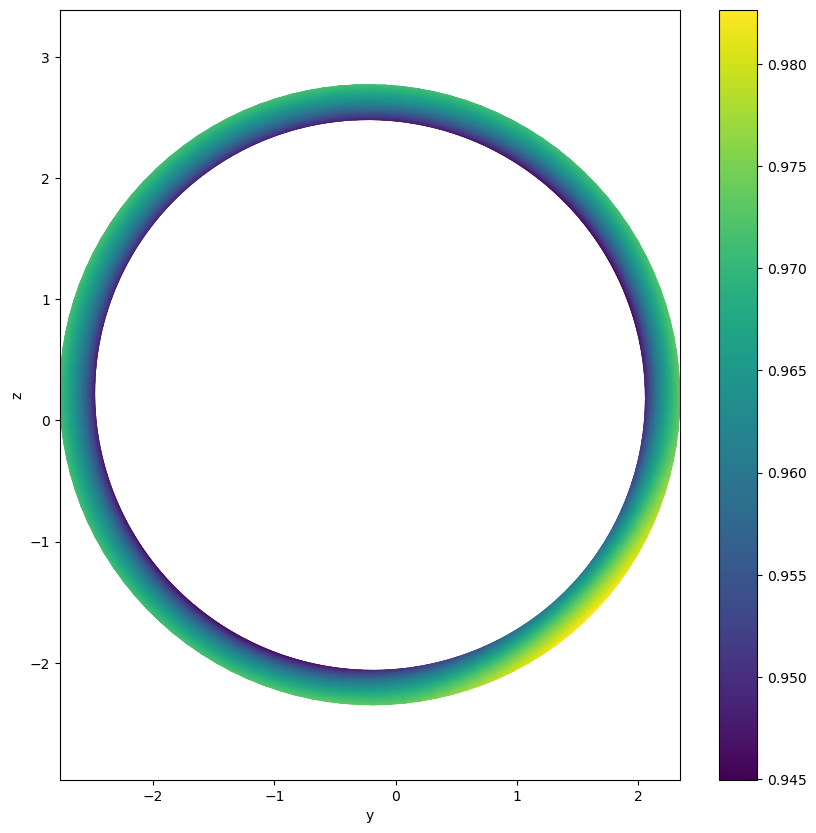

<Figure size 1000x1000 with 0 Axes>

In [38]:
# local volume
get_defplot_scalar3d(local_vol3d(u, MP_block), u, patches_u, kvs_u, MP_u, n_el, geos, lvol)


 patch: 0
(0.0, 1.0)
grid z: [0.5]

 patch: 0
cauchystress_inner= [0.00049289]
cauchystress_outer= [0.00031091]
volume_inner= [0.94909228]
volume_outer= [0.97295169]

 patch: 1

 patch: 2

 patch: 2
cauchystress_inner= [0.00048639]
cauchystress_outer= [0.00029432]
volume_inner= [0.94822977]
volume_outer= [0.97105922]

 patch: 3


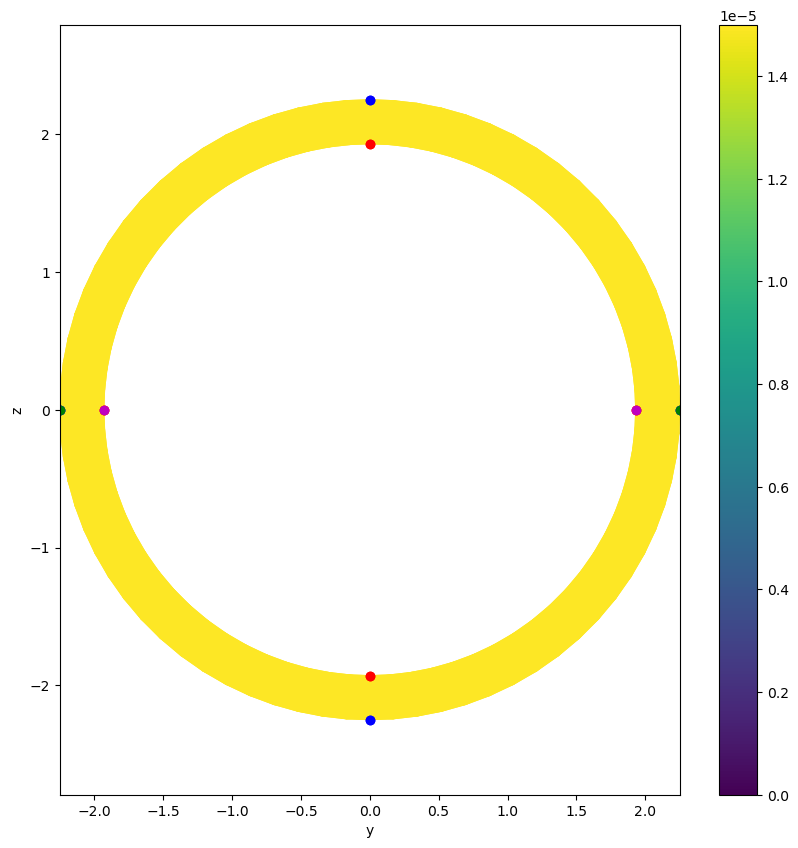

In [50]:
get_defplot_evalp3d(cauchystress3d(u, MP_block), local_vol3d(u, MP_block), patches_u, kvs_u, MP_u, n_el)

In [51]:
# solve linearized variational problem - iterative, without line-search
#initial value
u= np.zeros(dd)

max_err = 1e-11
solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []
vol= []



print(" without loading\n")

# set Neumann data via incremental loading
l_val = loading[-1]
neu_data = [(0,'bottom',gN0, l_val), (1,'bottom',gN0, l_val), (2,'bottom',gN0, l_val), (3,'bottom',gN0, l_val)] # set neumann

count = 0
while True:
    print(count)
    A, b = ass_nonlinsystem_RN3d(u, MP_block, neu_data, AR)
    print('Energy   =',J(u))
    u_d = make_solver(A).dot(b)
    
    ## error measure in H1*
    w= np.inner(np.transpose(u_d),b)
    err = np.sqrt(np.abs(w))
    print('Error=', err)

    #----------------------------------------------------#
    ud_array.append(u_d)
    normed_du = np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
    #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
    stepsize_du = normed_du # times alpha
    stepsizes.append(stepsize_du)
    #---------------------------------------------------#

    #if r < epsilon * r0: # break condition
    if abs(err) < max_err:
        break
    elif count == 25:
        break
        
    count+=1
    u += u_d  

#
ud_array.append(u_d) 
print('u= ' , u)
solutions.append(np.array(u))
iter_counts.append(count)

#loc_vol= local_vol (u, MP_block)
#vol.append(loc_vol)
    

 without loading

0
Energy   = 0.0
Error= 0.26097835317506657
1
Energy   = -0.012160088554184092
Error= 0.18326588372422828
2
Energy   = -0.029345557328823706
Error= 0.021004425671573415
3
Energy   = -0.02955562199946008
Error= 0.0034009526442044043
4
Energy   = -0.029559339706019615
Error= 0.0003403238076719311
5
Energy   = -0.029559636332043886
Error= 1.3117773005854239e-05
6
Energy   = -0.029559672473967923
Error= 3.3831914341909614e-08
7
Energy   = -0.029559672868414148
Error= 3.727651396133498e-13
u=  [0.16213757 0.14275637 0.10142689 ... 0.20605023 0.20594651 0.2057606 ]


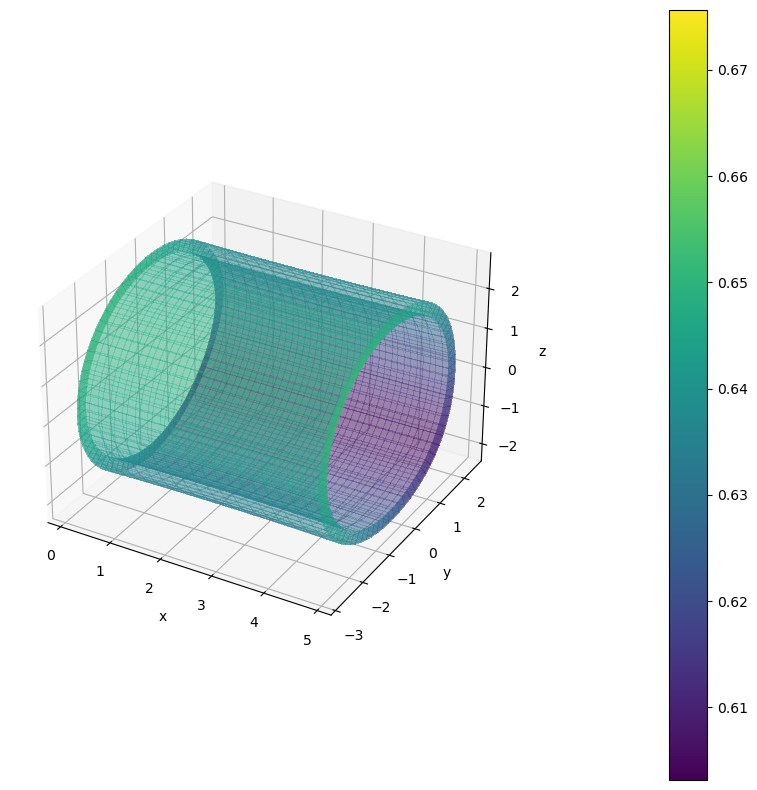

In [52]:
figsize(10,10)
fig = plt.figure()
ax = plt.axes(projection ='3d')
u1_funcs, u2_funcs, u3_funcs= split_u3d(u, MP_u, kvs_u, patches_u)
get_defplotU(u1_funcs, u2_funcs, u3_funcs, patches_u, kvs_u, MP_u)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

In [53]:
sum(iter_counts)

7

In [54]:
def global_vol3d (u, MP_block, kvs_j, r_inner=1.93, r_outer=2.25, h=5):
    detF= 0
    #kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration
    for p in range(MP_block.numpatches): # go through each patch
        #print('p=', p)
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components3d(X.T @ u, kvs_ux)
        f_term = '( idmat + grad(dis))'
        # sum/integrate
        detFp = sum(assemble.assemble(f' det({f_term}) *aux * dx',
                                  kvs_j, bfuns=[('aux', 1)], geo=geo_ux, dis=dis, idmat=np.identity(3)).ravel())
        print(detFp)
        detF+=detFp
        print('global volume:',detF)
    vol_ratio= detF/((r_outer**2 - r_inner**2) *np.pi *h)
    return vol_ratio # global deformed volume relatively to undeformed volume (3D)

In [55]:
global_vol3d(u, MP_block, kvs_j)

5.053026597938072
global volume: 5.053026597938072
5.084116135269571
global volume: 10.137142733207643
5.0530265979380715
global volume: 15.190169331145714
5.052975795379885
global volume: 20.243145126525597


0.9634559242264235

In [56]:
r_inner=1.93
r_outer=2.25

In [57]:
(r_outer**2 - r_inner**2) *np.pi *5

21.010971667208537

In [58]:
j = 0
for p in range(MP_block.numpatches): # go through each patch
    X = MP_block.patch_to_global(p)
    kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

    dis = get_components3d(X.T @ u, kvs_ux)
    detF= sum(assemble.assemble( '(tr(grad(dis))+tr(idmat))  * aux * dx',kvs_ux, bfuns=[('aux',1)], geo=geo_ux, dis=dis, idmat=np.identity(3)).ravel())
    print(detF)

15.658711984827548
15.670584233840723
15.658711984827546
15.659927596723943
